In [3]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the data directory path
data_dir = '/content/drive/MyDrive/mri'  # Update to your specific path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
base_dir = '/content/drive/MyDrive/mri/BraTS2020_TrainingData'  # Update as per your actual path


In [5]:
# Install nibabel if not already installed
!pip install nibabel

import nibabel as nib
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
import os
from glob import glob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 28.5 MB/s eta 0:00:00


In [6]:
!pip install torch torchvision nibabel
!pip install nibabel
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import nibabel as nib
import numpy as np



In [7]:
import os
for root, _, files in os.walk(base_dir):
    for file in files:
        if file.endswith('.nii'):
            print(os.path.join(root, file))


/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_seg.nii
/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_flair.nii
/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_t1.nii
/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_t1ce.nii
/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_365/BraTS20_Training_365_t2.nii
/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_seg.nii
/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_369/BraTS20_Training_369_flair.nii
/content/drive/MyDrive/mri/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20

In [8]:
import os
import glob
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Custom Dataset class
class MRIDataset(Dataset):
    def __init__(self, base_dir, transform=None, sample_size=50):
        self.transform = transform
        # Gather all image paths (consider nested folders)
        self.image_paths = glob.glob(os.path.join(base_dir, '**', '*.nii'), recursive=True)

        # Sample only up to 50 images if available
        if len(self.image_paths) > sample_size:
            self.image_paths = random.sample(self.image_paths, sample_size)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        # Load the MRI image as needed and apply transformations
        image_data = nib.load(image_path).get_fdata()

        # Convert to a PIL image and apply transformations if defined
        image = Image.fromarray(image_data[..., image_data.shape[2] // 2])  # Take the middle slice for 2D representation
        if self.transform:
            image = self.transform(image)

        return image

# Directory containing MRI images
base_dir = '/content/drive/MyDrive/mri/BraTS2020_TrainingData'

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Initialize Dataset and DataLoader
dataset = MRIDataset(base_dir=base_dir, transform=transform, sample_size=50)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Check if dataloader loads correctly
for i, batch in enumerate(dataloader):
    print(f"Batch {i+1} loaded with shape: {batch.shape}")
    if i == 1:  # Just load two batches to verify
        break


Batch 1 loaded with shape: torch.Size([16, 1, 256, 256])
Batch 2 loaded with shape: torch.Size([16, 1, 256, 256])


In [9]:
import torch
import torch.nn as nn

# Define the Generator model
class Generator(nn.Module):
    def __init__(self, noise_dim=100, img_channels=1):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(noise_dim, 128, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.ConvTranspose2d(32, img_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# Define the Discriminator model
class Discriminator(nn.Module):
    def __init__(self, img_channels=1):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(img_channels, 32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Flatten()
        )

    def forward(self, x):
        return self.main(x)

 # Set up the device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


# Initialize the models
noise_dim = 100
G = Generator(noise_dim=noise_dim).to(device)
D = Discriminator().to(device)

# Display model architectures
print("Generator model summary:")
print(G)
print("\nDiscriminator model summary:")
print(D)


Using device: cpu
Generator model summary:
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)

Discriminator model summary:
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negativ

In [10]:
from torch import optim
from torchvision.utils import save_image
from PIL import Image  # Add this import for PIL image handling


# Training parameters
num_epochs = 70  # Set this lower initially, like 10, for testing if RAM is a concern
batch_size = 16
learning_rate = 0.00005  # Lower learning rate often works better with WGAN
n_critic = 5  # Number of updates for Discriminator per Generator update
clip_value = 0.01  # Clipping value for weights in WGAN

# Optimizers
optimizer_D = optim.RMSprop(D.parameters(), lr=learning_rate)
optimizer_G = optim.RMSprop(G.parameters(), lr=learning_rate)

# Start the training loop
for epoch in range(num_epochs):
    for i, real_images in enumerate(dataloader):  # Only unpack the image
        # Move real images to the selected device
        real_images = real_images.to(device)
        b_size = real_images.size(0)

        # Train the Discriminator
        optimizer_D.zero_grad()

        # Generate noise and create fake images
        noise = torch.randn(real_images.size(0), noise_dim, 1, 1, device=device)
        fake_images = G(noise).detach()

        # Calculate D's loss on real and fake images
        loss_D_real = -torch.mean(D(real_images))
        loss_D_fake = torch.mean(D(fake_images))
        loss_D = loss_D_real + loss_D_fake

        # Backprop and update Discriminator weights
        loss_D.backward()
        optimizer_D.step()

        # Clip Discriminator weights for WGAN
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the Generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # Generate fake images for the Generator
            fake_images = G(noise)
            loss_G = -torch.mean(D(fake_images))

            # Backprop and update Generator weights
            loss_G.backward()
            optimizer_G.step()

    # Print the losses
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss D: {loss_D.item()}, Loss G: {loss_G.item()}")

    # Optional: Save some generated images to observe progress
    if epoch % 10 == 0:
        with torch.no_grad():
            fake_images = G(noise).cpu()
            save_image(fake_images[:16], f"generated_images_epoch_{epoch}.png", nrow=4, normalize=True)


Epoch [1/70] Loss D: -0.0012777855154126883, Loss G: 0.0026495466008782387
Epoch [2/70] Loss D: -0.0019489212427288294, Loss G: 0.0019331625662744045
Epoch [3/70] Loss D: -0.0019336231052875519, Loss G: 0.0018210145644843578
Epoch [4/70] Loss D: -0.0021684260573238134, Loss G: 0.0012021779548376799
Epoch [5/70] Loss D: -0.003479001112282276, Loss G: 0.0011116656241938472
Epoch [6/70] Loss D: -0.0031061707995831966, Loss G: 0.0014276753645390272
Epoch [7/70] Loss D: -0.003680688561871648, Loss G: 0.0012370565673336387
Epoch [8/70] Loss D: -0.0051344409584999084, Loss G: 0.0018992775585502386
Epoch [9/70] Loss D: -0.004674239084124565, Loss G: 0.0030411190818995237
Epoch [10/70] Loss D: -0.006925767753273249, Loss G: 0.003323216922581196
Epoch [11/70] Loss D: -0.0075379628688097, Loss G: 0.004267812706530094
Epoch [12/70] Loss D: -0.008197121322154999, Loss G: 0.004908164031803608
Epoch [13/70] Loss D: -0.00935448706150055, Loss G: 0.005710190627723932
Epoch [14/70] Loss D: -0.0085764881

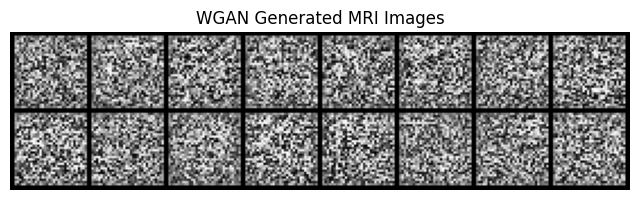

In [11]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Display a batch of generated images
def display_generated_images(images, title="Generated Images"):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.title(title)
    plt.imshow(np.transpose(vutils.make_grid(images, padding=2, normalize=True).cpu(), (1, 2, 0)))
    plt.show()

# Fetch a batch of generated images and display them
noise = torch.randn(16, noise_dim, 1, 1, device=device)  # Adjust batch size if needed
with torch.no_grad():
    fake_images = G(noise).detach().cpu()

display_generated_images(fake_images, title="WGAN Generated MRI Images")
